In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.classical import expr
def get_register_counts(counts: dict[str, int], creg_sizes: list[int], target_reg_name: str, 
                        reg_names: list[str]) -> dict[str, int]:
    """If the circuit has multiple target registers, this function can be used to get the counts of a specific target register.

    Args:
        counts (dict[str, int]): the counts of the circuit, e.g. {'0000000': 100, '0000001': 100, '0000010': 100, '0000011': 100, '0000100': 100, '0000101': 100, '0000110': 100, '0000111': 100}
        reg_names (list[str]): the names of the classical registers, e.g. ['a', 't']
        creg_sizes (list[int]): the sizes of the corresponding classical registers of `reg_names`, e.g. [3, 4]
        target_reg_name (str): the name of the register that we want to get the counts of, e.g. 't'

    Returns:
        dict[str, int]: the counts of the target register
    """
    idx = reg_names.index(target_reg_name)
    start = sum(creg_sizes[:idx])
    end = start + creg_sizes[idx]

    reg_counts = {}
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(" ", "") # remove spaces
        bitstring = bitstring[::-1]  # little endian
        reg_bits = bitstring[start:end][::-1]
        reg_counts[reg_bits] = reg_counts.get(reg_bits, 0) + count
    return reg_counts


In [98]:
def get_fanout_circuit(n_tgts: int, init_bitstr: str) -> QuantumCircuit:
    assert n_tgts % 2 == 0
    n_ancs = n_tgts
    ctrl = QuantumRegister(1, 'c')
    ancs = [QuantumRegister(1, f'a{i}') for i in range(n_ancs)]
    tgts = [QuantumRegister(1, f't{i}') for i in range(n_tgts)]
    anc_cregs = ClassicalRegister(n_tgts, f'anc_cregs')
    tgt_cregs = ClassicalRegister(n_tgts, f'tgt_cregs')
    ctrl_creg = ClassicalRegister(1, f'ctrl_creg')
    all_regs = [reg for pair in zip(ancs, tgts) for reg in pair]
    # cregs = ClassicalRegister(2*n_tgts + 1, f'cregs')
    qc = QuantumCircuit(ctrl, *all_regs, ctrl_creg, anc_cregs, tgt_cregs)
    qc.initialize(init_bitstr)

    qc.measure(ctrl, ctrl_creg)
    for i in range(n_tgts):
        qc.measure(tgts[i], tgt_cregs[i])
        qc.measure(ancs[i], anc_cregs[i])

    return qc

    for i in range(0, n_ancs, 2):
        # step 1
        qc.h(ancs[i])
        qc.cx(tgts[i], ancs[i+1])

        # step 2
        qc.cx(ancs[i], tgts[i])

    # step 3
    for i in range(-1, n_tgts-1):
        if i == -1:
            qc.cx(ctrl, ancs[0])
        else:
            qc.cx(tgts[i], ancs[i+1])

    for i in range(1, n_tgts, 2):
        # step 4:
        qc.cx(ancs[i], tgts[i])

        # step 5
        qc.h(ancs[i])

    # step 5':
    for i in range(1, n_tgts-1, 2):
        qc.cx(tgts[i], ancs[i+1])

    # return qc
    # step 6
    for anc, creg in zip(ancs, anc_cregs):
        qc.measure(anc, creg)

    # step 7-1
    parity_for_Z_on_ctrl = expr.lift(anc_cregs[i])
    for i in range(3, n_ancs, 2):
        parity_for_Z_on_ctrl = expr.bit_xor(anc_cregs[i], parity_for_Z_on_ctrl)

    with qc.if_test(parity_for_Z_on_ctrl):
        qc.z(ctrl)
    
    # step 7-2
    exprs_X_on_tgts = []
    for i in range(0, n_ancs, 2):
        if i == 0:
            e = expr.lift(anc_cregs[i])
        else:
            e = expr.bit_xor(anc_cregs[i], exprs_X_on_tgts[-1])
        exprs_X_on_tgts.append(e)

        with qc.if_test(e):
            qc.x(tgts[i])
            qc.x(tgts[i+1])
    
    qc.measure(ctrl, ctrl_creg)

    for tgt, creg in zip(tgts, tgt_cregs):
        qc.measure(tgt, creg)
    
    return qc
n_tgts = 4
init_tgt_bits = [1, 0, 1, 0]
initial_state = [0] + [reg for pair in zip([0] * n_tgts, init_tgt_bits) for reg in pair]
init_bitstr = "".join(map(str, initial_state))
print(init_bitstr)
circ = get_fanout_circuit(n_tgts, init_bitstr)
# print(circ.draw("latex_source"))
print(circ.draw(style="mpl"))

# circ.initialize("".join(map(str, initial_state[::-1])))
# circ.save_statevector()
rst = AerSimulator(method="statevector").run(circ).result()

print(f"initial state: {initial_state} {init_bitstr}")
print(f"target bits: {init_tgt_bits}")
# print(rst.get_statevector())
print(rst)
counts = rst.get_counts()
for measurement in counts:
    # for i in range(len(rst)):
    print(rst.data)
    print(measurement)
    measurement = measurement.replace(" ", "")
    # Assuming the bit string format is "ctrl tgts ancs"
    ctrl_bit = measurement[0]  # last bit is ctrl
    tgt_bits = measurement[1:n_tgts+1]  # middle bits are targets
    anc_bits = measurement[n_tgts+1:]  # first bits are ancillas
    print(f"Measurement: {measurement}")
    print(f"  Control: {ctrl_bit}")
    print(f"  Targets: {tgt_bits}")
    print(f"  Ancillas: {anc_bits}")


001000100
             ┌────────────────────────────────┐┌─┐                        
          c: ┤0                               ├┤M├────────────────────────
             │                                │└╥┘   ┌─┐                  
         a0: ┤1                               ├─╫────┤M├──────────────────
             │                                │ ║ ┌─┐└╥┘                  
         t0: ┤2                               ├─╫─┤M├─╫───────────────────
             │                                │ ║ └╥┘ ║    ┌─┐            
         a1: ┤3                               ├─╫──╫──╫────┤M├────────────
             │                                │ ║  ║  ║ ┌─┐└╥┘            
         t1: ┤4 Initialize(0,0,1,0,0,0,1,0,0) ├─╫──╫──╫─┤M├─╫─────────────
             │                                │ ║  ║  ║ └╥┘ ║    ┌─┐      
         a2: ┤5                               ├─╫──╫──╫──╫──╫────┤M├──────
             │                                │ ║  ║  ║  ║  ║ ┌─┐└╥┘      
         t2: ┤6

In [355]:
cregs1 = ClassicalRegister(2, "creg1")
cregs2 = ClassicalRegister(3, "creg2")
cregs3 = ClassicalRegister(1, "creg3")
cregs = ClassicalRegister(6, "cregs")
qregs = QuantumRegister(6)
qc = QuantumCircuit(qregs, cregs1, cregs2, cregs3)
qc.initialize("01011+")
qc.measure(0, cregs1[0])
qc.measure(1, cregs1[1])
qc.measure(2, cregs2[0])
qc.measure(3, cregs2[1])
qc.measure(4, cregs2[2])
qc.measure(5, cregs3[0])
print(qc.draw())

counts = AerSimulator(method="statevector").run(qc).result().get_counts()
print(counts)

         ┌──────────────────────────┐┌─┐               
   q9_0: ┤0                         ├┤M├───────────────
         │                          │└╥┘┌─┐            
   q9_1: ┤1                         ├─╫─┤M├────────────
         │                          │ ║ └╥┘┌─┐         
   q9_2: ┤2                         ├─╫──╫─┤M├─────────
         │  Initialize(0,1,0,1,1,+) │ ║  ║ └╥┘┌─┐      
   q9_3: ┤3                         ├─╫──╫──╫─┤M├──────
         │                          │ ║  ║  ║ └╥┘┌─┐   
   q9_4: ┤4                         ├─╫──╫──╫──╫─┤M├───
         │                          │ ║  ║  ║  ║ └╥┘┌─┐
   q9_5: ┤5                         ├─╫──╫──╫──╫──╫─┤M├
         └──────────────────────────┘ ║  ║  ║  ║  ║ └╥┘
creg1: 2/═════════════════════════════╩══╩══╬══╬══╬══╬═
                                      0  1  ║  ║  ║  ║ 
creg2: 3/═══════════════════════════════════╩══╩══╩══╬═
                                            0  1  2  ║ 
creg3: 1/═══════════════════════════════════════

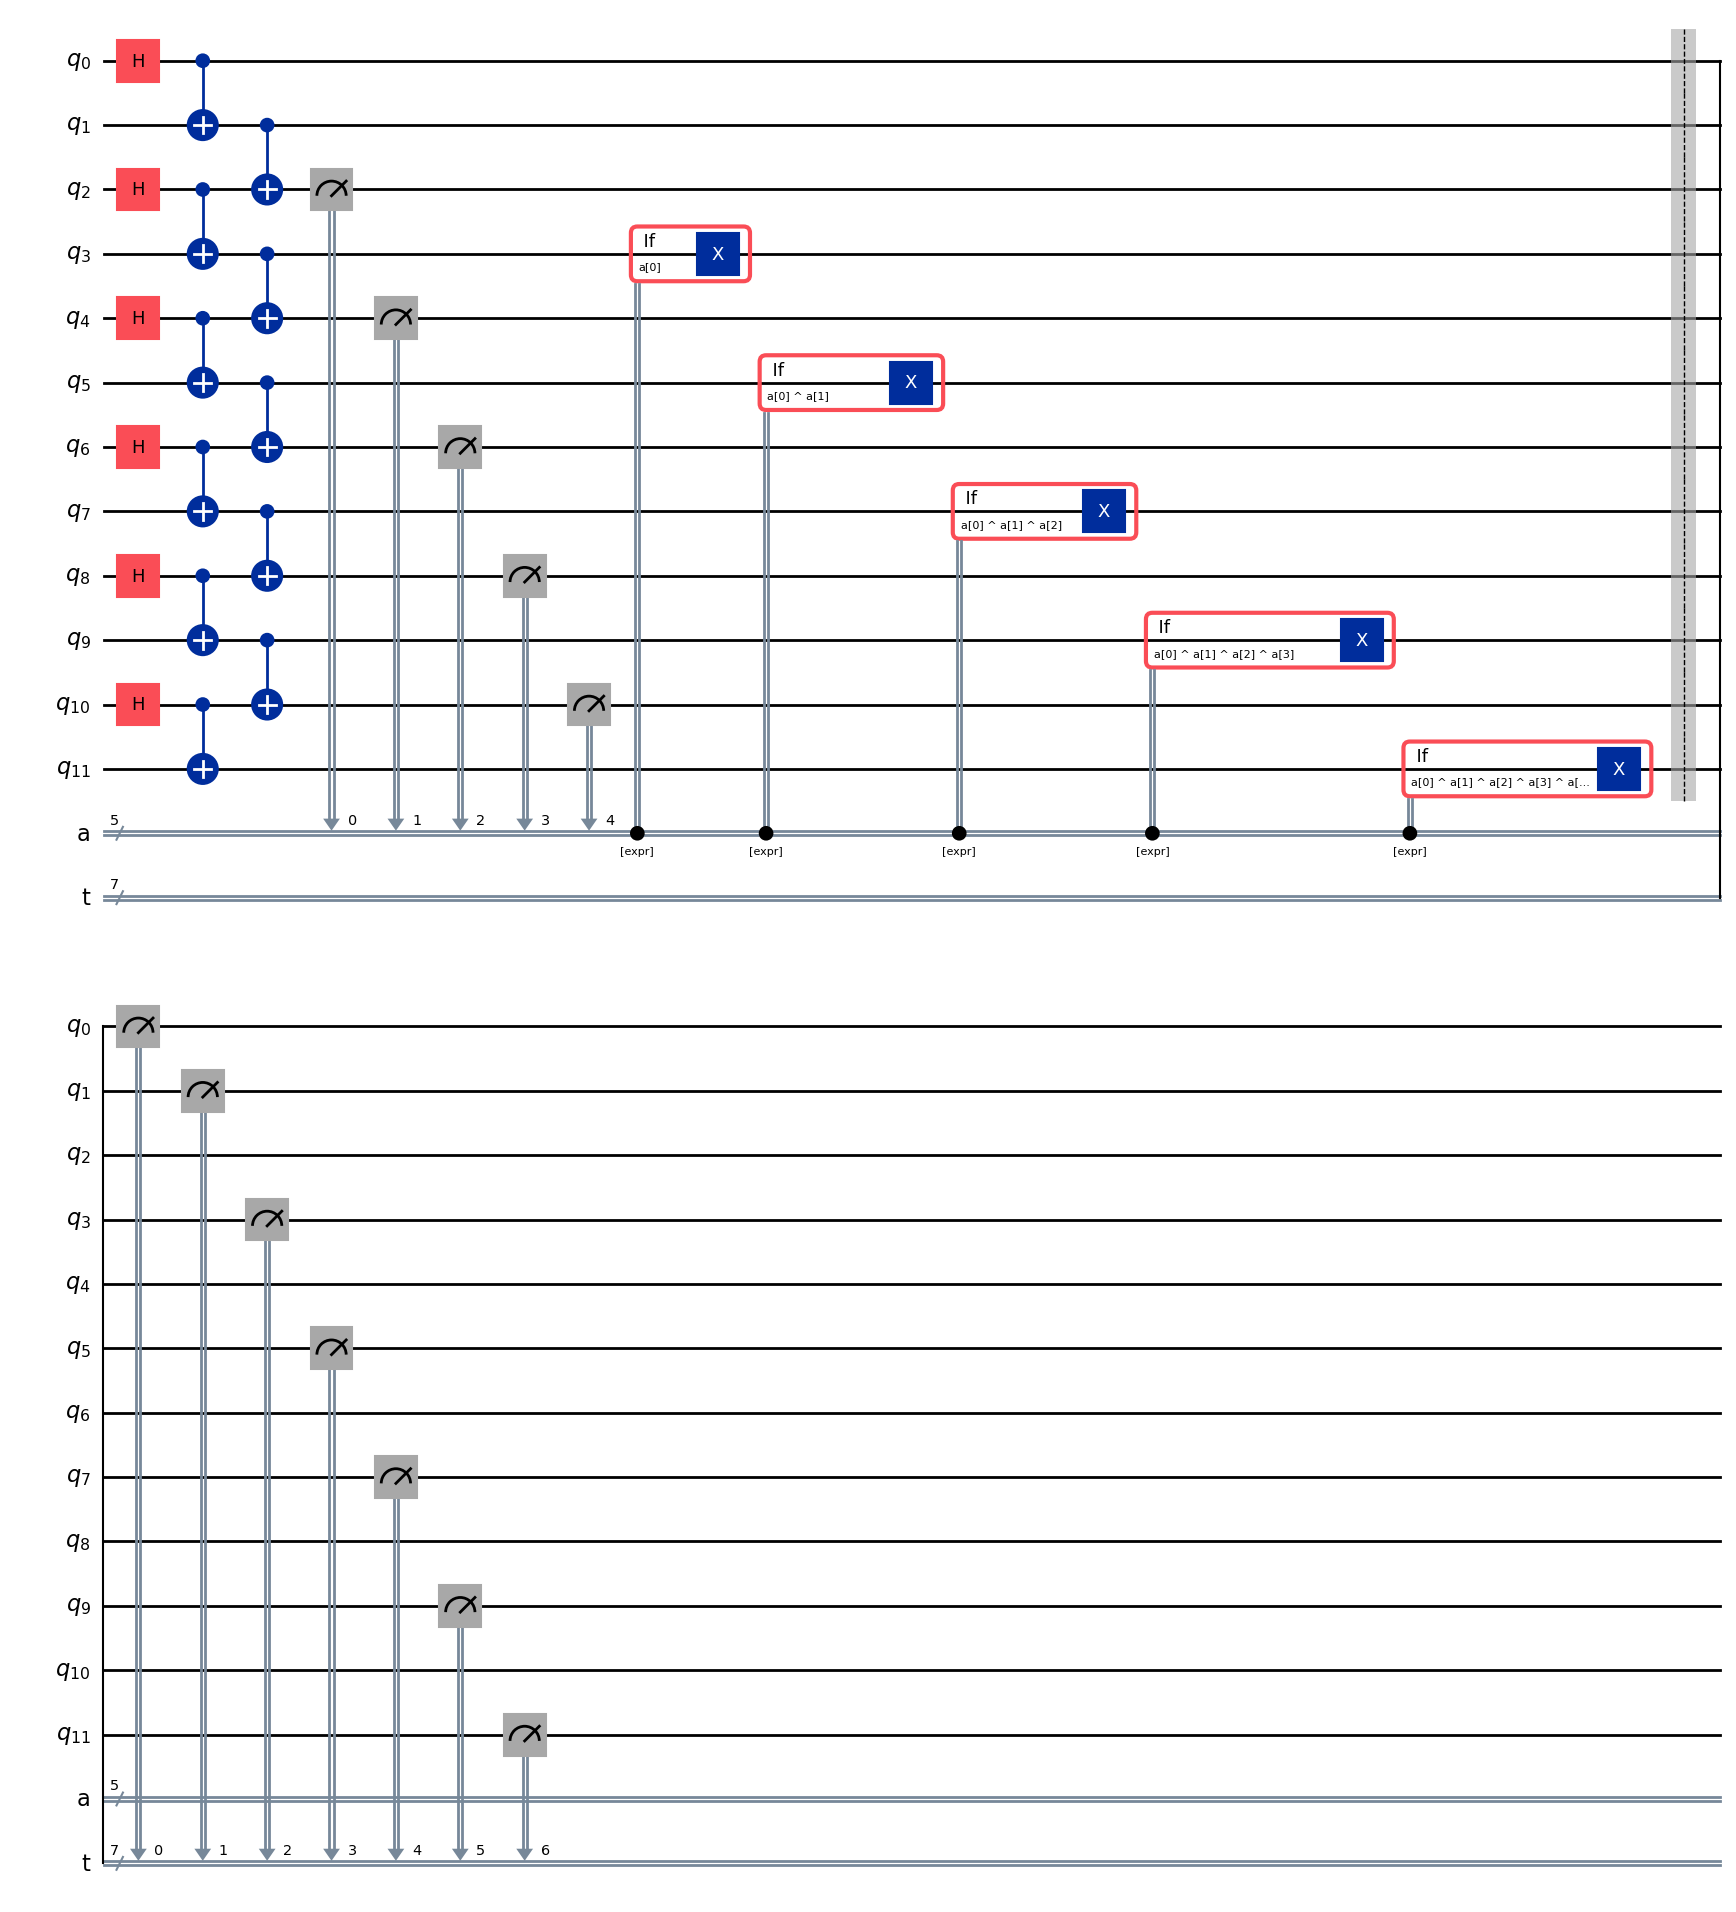

In [146]:


def get_GHZ_circ(n: int) -> QuantumCircuit:
    assert n % 2 == 1 and n > 2
    n -= 1
    qr = QuantumRegister(2 * n, 'q')
    anc_cr = ClassicalRegister(n - 1, 'a')
    tgt_cr = ClassicalRegister(n + 1, 't')
    circ = QuantumCircuit(qr, anc_cr, tgt_cr)
 
    for m in range(n):
        circ.h(2 * m)
 
    for m in range(n):
        circ.cx(2 * m, 2 * m + 1)
 
    for m in range(n - 1):
        circ.cx(2 * m + 1, 2 * m + 2)
 
    for m in range(n - 1):
        circ.measure(2 * m + 2, anc_cr[m])
 
    for m in range(0, n - 1):
        _condition = anc_cr[m] if m == 0 else expr.bit_xor(_condition, anc_cr[m])
        with circ.if_test(expr.lift(_condition)):
            circ.x(2 * m + 3)

    circ.barrier()

    circ.measure(0, tgt_cr[0])
    for i in range(0, n):
        circ.measure(2 * i + 1, tgt_cr[i+1])
 
    return circ

n_qubits = 7
qc = get_GHZ_circ(n_qubits)
# qc.measure_all()
qc.draw("mpl")
# print(qc.draw("mpl"))


In [147]:
counts = AerSimulator(method="statevector").run(qc).result().get_counts()


reg_counts = get_register_counts(
    counts, [n_qubits-2, n_qubits], 't', ['a', 't'])
print(reg_counts)


{'1111111': 504, '0000000': 520}


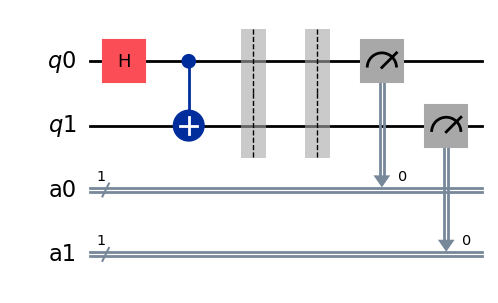

In [14]:
def get_GHZ_circ_w_reset(
        circ: QuantumCircuit,
        qr: list[QuantumRegister],
        anc_cr: list[ClassicalRegister],
        n: int, meas_all: bool = False):
    assert n % 2 == 0
    half_n = n // 2
    # qr = QuantumRegister(n, 'q')
    # qr = [QuantumRegister(1, f'q{i}') for i in range(n)]
    # tgt_cr = ClassicalRegister(2 * half_n, 't')
    # anc_cr = ClassicalRegister(n, 'a')
    # anc_cr = [ClassicalRegister(1, f'a{i}') for i in range(n)]
    # tgt_cr = ClassicalRegister(half_n + 1, 't')
    # circ = QuantumCircuit(*qr, *anc_cr)
 
    for m in range(half_n):
        circ.h(qr[2 * m])
 
    for m in range(half_n):
        circ.cx(qr[2 * m], qr[2 * m + 1])
 
    for m in range(half_n - 1):
        circ.cx(qr[2 * m + 1], qr[2 * m + 2])
 
    for m in range(half_n - 1):
        circ.measure(qr[2 * m + 2], anc_cr[2 * m + 2])
 
    for m in range(half_n - 1):
        measured_idx = 2 * m + 2
        _condition = anc_cr[measured_idx] if m == 0 else expr.bit_xor(_condition, anc_cr[measured_idx])
        with circ.if_test(expr.equal(_condition, 1)):
            circ.x(qr[2 * m + 3])

    circ.barrier()

    for i in range(half_n - 1):
        circ.reset(qr[2 * i + 2])
        circ.cx(qr[2 * i + 1], qr[2 * i + 2])

    circ.barrier()
    
    if meas_all:
        for i in range(n):
            circ.measure(qr[i], anc_cr[i])
 
    # return circ

n_qubits = 2
qr = [QuantumRegister(1, f'q{i}') for i in range(n_qubits)]
anc_cr = [ClassicalRegister(1, f'a{i}') for i in range(n_qubits)]
qc = QuantumCircuit(*qr, *anc_cr)
get_GHZ_circ_w_reset(qc, qr, anc_cr, n_qubits, meas_all=True)
qc.draw("mpl")
# print(qc.draw("mpl"))


In [15]:
counts = AerSimulator(method="statevector").run(qc).result().get_counts()
print(counts)


{'0 0': 495, '1 1': 529}


01000100


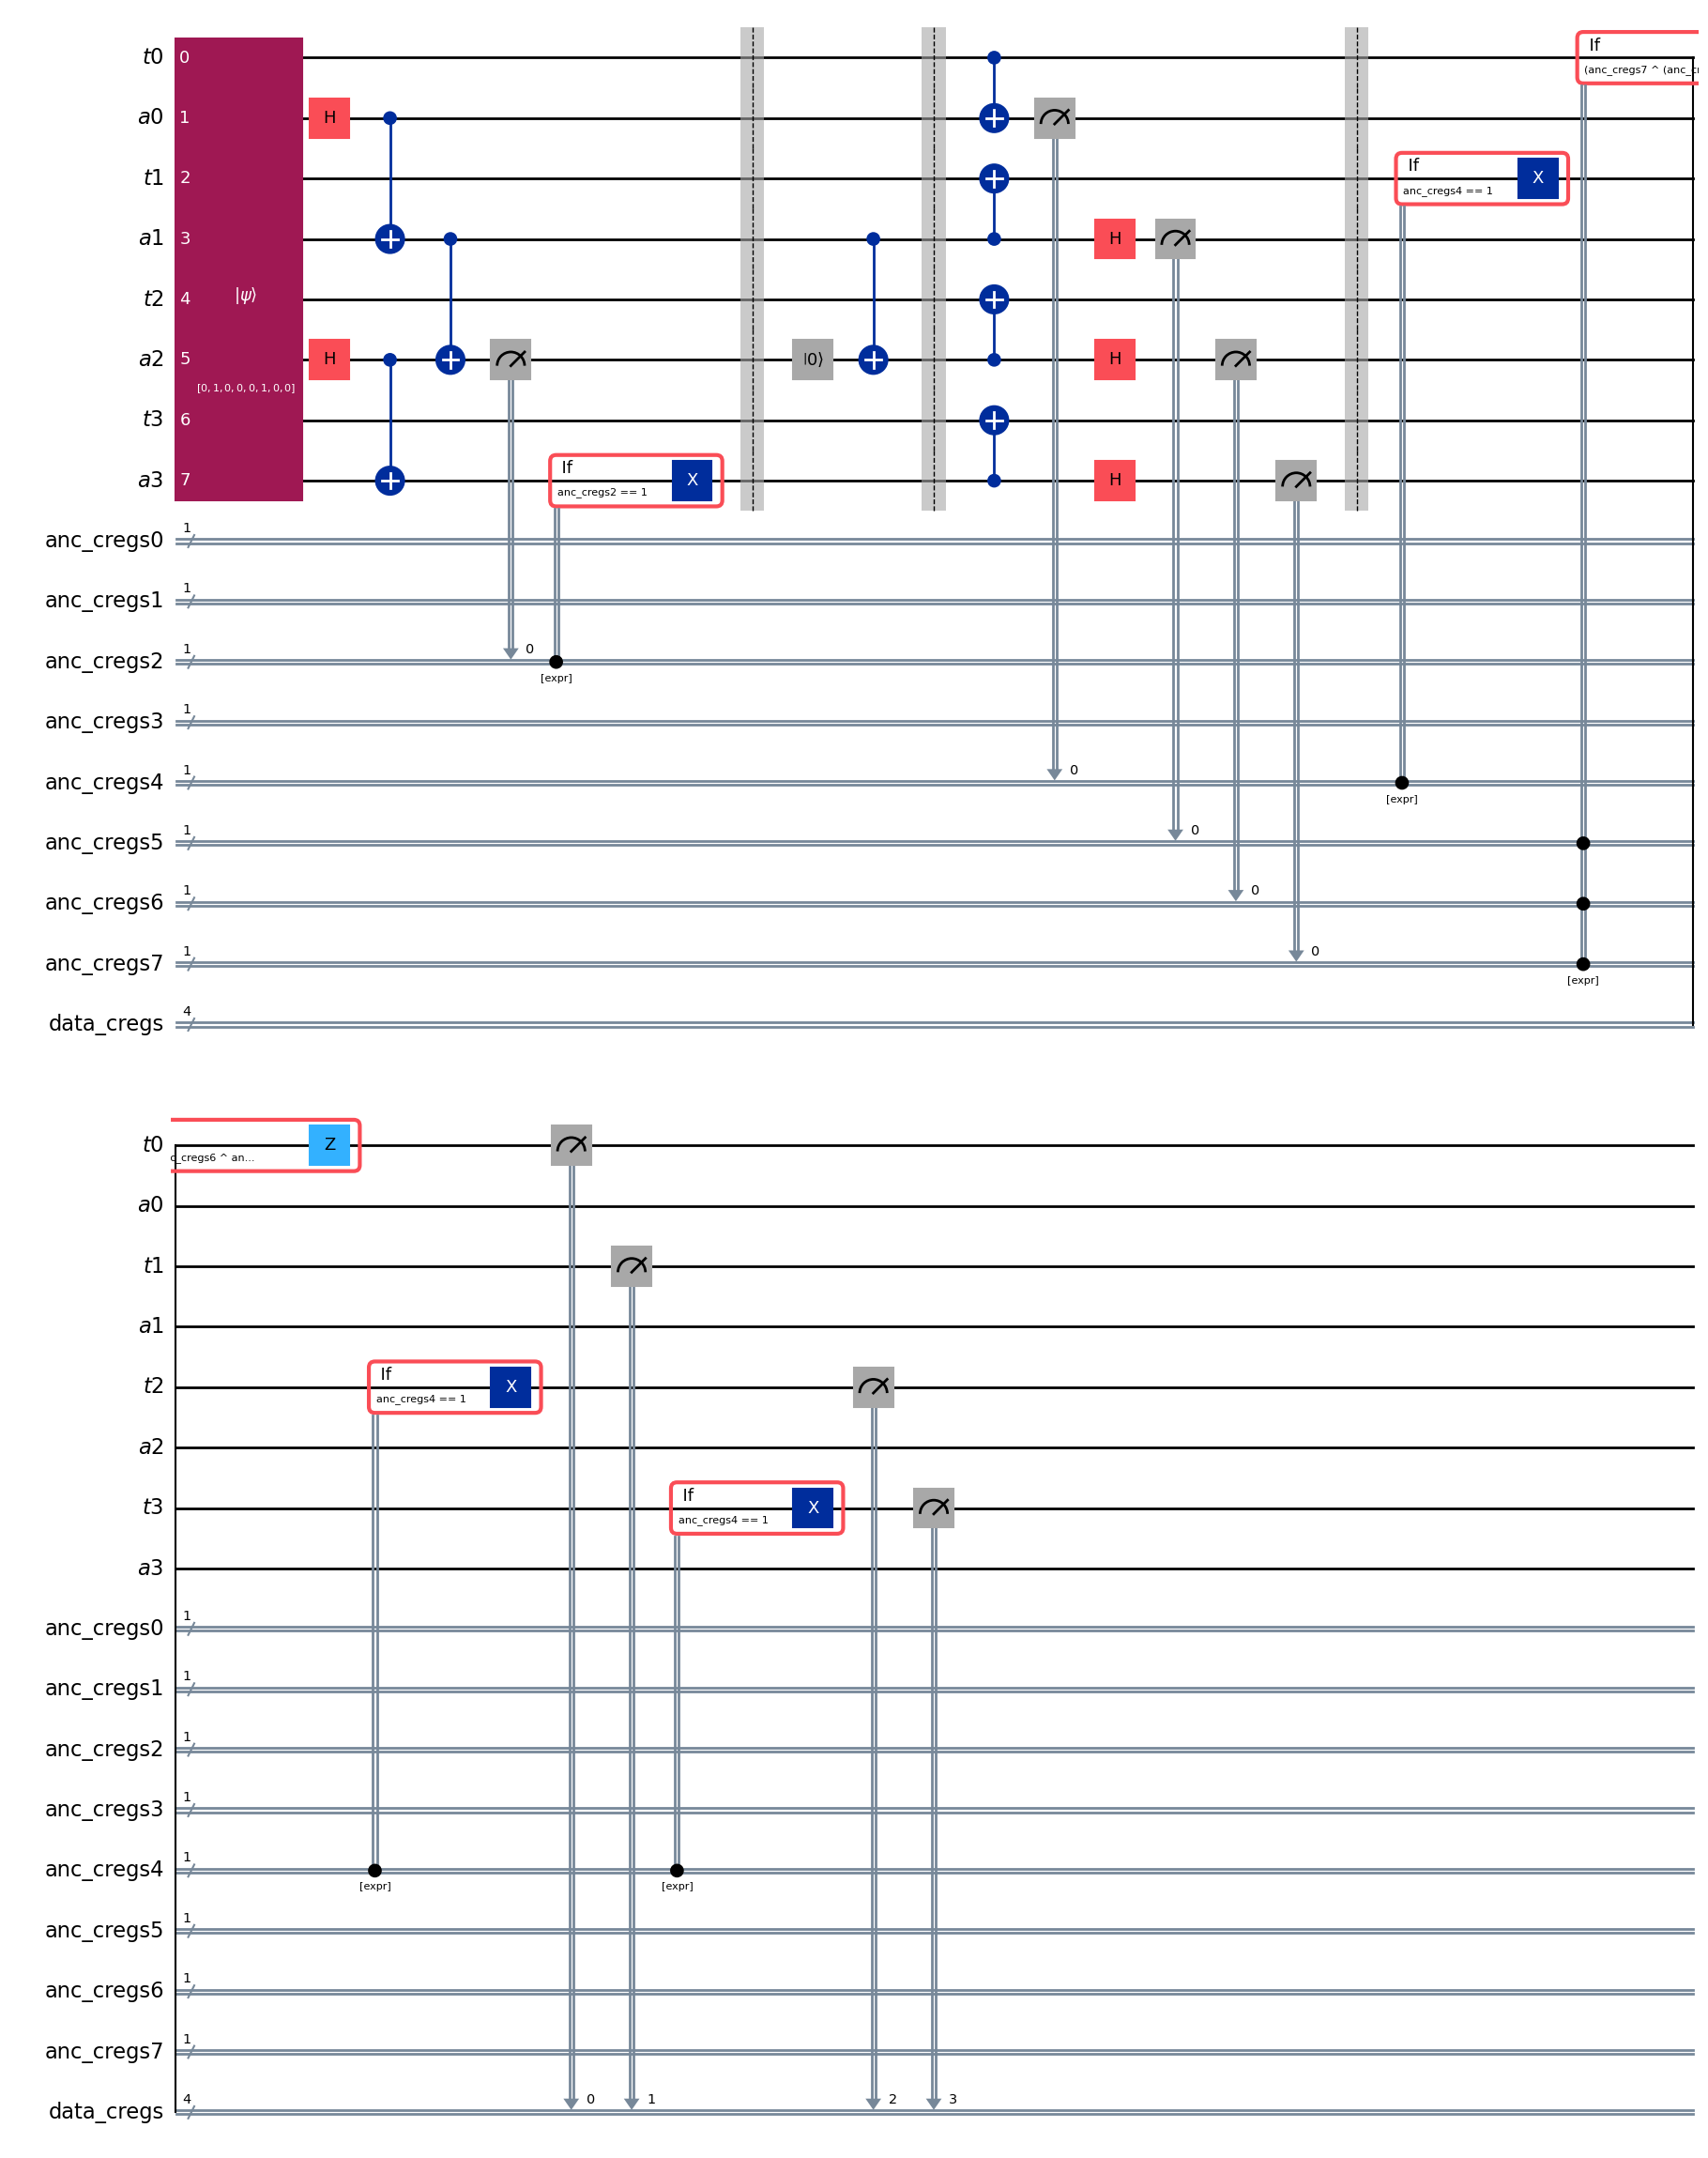

In [28]:
def get_Fanout_circ_by_GHZ_w_reset(n_tgts: int, init_bitstr: str | None = None, meas_all: bool = False) -> QuantumCircuit:
    # c, a1, t1, a2, t2, ...
    # 0,  1,  2,  3,  4, ...
    n_GHZ = n_tgts + 1
    n_total = 2 * (n_tgts + 1) # 1 for ctrl
    # ctrl = QuantumRegister(1, 'c')
    ancs = [QuantumRegister(1, f'a{i}') for i in range(n_GHZ)]
    qubits = [QuantumRegister(1, f't{i}') for i in range(n_GHZ)]
    anc_cregs = [ClassicalRegister(1, f'anc_cregs{i}') for i in range(2*n_GHZ)]
    # GHZ_anc_cregs = [ClassicalRegister(1, f'GHZ_anc_cregs{i}') for i in range(n_GHZ)]
    qubit_cregs = ClassicalRegister(n_GHZ, f'data_cregs')
    ctrl = qubits[0]
    # print(GHZ_circ)
    all_regs = [reg for pair in zip(qubits, ancs) for reg in pair]
    qc = QuantumCircuit(*all_regs, *anc_cregs, qubit_cregs)
    if init_bitstr is not None:
        qc.initialize(init_bitstr)
    get_GHZ_circ_w_reset(qc, ancs, anc_cregs[:n_GHZ], n_GHZ)
    # print(f"{len(qc.qubits)=}")
    # for qubit in qc.qubits:
    #     print(qubit)
    # qc.initialize(init_bitstr)
    # print(qc.clbits)
    # qc.compose(GHZ_circ, 
    #            qubits=[2 * i + 1 for i in range(n_GHZ)],
    #            clbits=[i for i in range(n_GHZ)],
    #            inplace=True)
    # # print(qc.clbits)
    # for clbit in qc.clbits:
    #     print(clbit)

    # print(qc)
    
    qc.cx(ctrl, ancs[0])
    # qc.cx(ctrl, ancs[0])
    qc.measure(ancs[0], anc_cregs[n_GHZ+0])
    for i in range(n_tgts):
        qc.cx(ancs[i+1], qubits[i+1])
        # qc.cx(qubits[i+1], ancs[i+1])
        qc.h(ancs[i+1])
        qc.measure(ancs[i+1], anc_cregs[n_GHZ+i+1])

    qc.barrier()

    for i in range(n_tgts):
        with qc.if_test(expr.equal(anc_cregs[n_GHZ+0], 1)):
            qc.x(qubits[i+1])

    parity_for_Z_on_ctrl = expr.lift(anc_cregs[n_GHZ+1])
    for i in range(2, n_GHZ):
        parity_for_Z_on_ctrl = expr.bit_xor(anc_cregs[n_GHZ+i], parity_for_Z_on_ctrl)

    with qc.if_test(expr.equal(parity_for_Z_on_ctrl, 1)):
        qc.z(ctrl)

    if meas_all:
        for i in range(n_GHZ):
            qc.measure(qubits[i], qubit_cregs[i])
    return qc

n_tgts = 3
n_qubits = n_tgts + 1
init_tgt_bits = [1, 0, 1, 0]
initial_state = [reg for pair in zip([0] * n_qubits, init_tgt_bits) for reg in pair]
init_bitstr = "".join(map(str, initial_state))
# init_bitstr = '+' + init_bitstr[1:]
print(init_bitstr)

qc = get_Fanout_circ_by_GHZ_w_reset(n_tgts, init_bitstr, meas_all=True)
# print(qc)
qc.draw("mpl")


    

In [29]:

counts = AerSimulator(method="statevector").run(qc).result().get_counts()
# print(counts)
for measurement in counts:
    print(measurement)
reg_counts = get_register_counts(counts, [(n_tgts + 1)*2, n_tgts + 1], 't', ['a', 't'])
print(reg_counts)

1010 0 0 1 1 0 0 0 0
1010 1 1 1 0 0 0 0 0
1010 1 0 0 0 0 0 0 0
1010 1 1 1 1 0 0 0 0
1010 0 0 0 0 0 1 0 0
1010 1 0 1 1 0 0 0 0
1010 0 1 0 0 0 0 0 0
1010 0 1 0 0 0 1 0 0
1010 1 1 1 0 0 1 0 0
1010 0 0 0 1 0 0 0 0
1010 1 0 0 1 0 0 0 0
1010 0 1 1 1 0 0 0 0
1010 1 1 0 1 0 0 0 0
1010 1 1 1 1 0 1 0 0
1010 0 1 0 1 0 1 0 0
1010 0 1 1 0 0 0 0 0
1010 0 0 0 0 0 0 0 0
1010 1 0 0 1 0 1 0 0
1010 0 0 1 0 0 1 0 0
1010 1 1 0 0 0 0 0 0
1010 1 0 0 0 0 1 0 0
1010 0 1 1 0 0 1 0 0
1010 0 0 0 1 0 1 0 0
1010 0 1 1 1 0 1 0 0
1010 1 0 1 0 0 1 0 0
1010 1 1 0 1 0 1 0 0
1010 1 0 1 0 0 0 0 0
1010 0 0 1 0 0 0 0 0
1010 1 0 1 1 0 1 0 0
1010 0 0 1 1 0 1 0 0
1010 0 1 0 1 0 0 0 0
1010 1 1 0 0 0 1 0 0
{'1010': 1024}


# Verify Fanout with GHZ

In [ ]:


def get_Fanout_circ_by_GHZ_w_reset(n_tgts: int, init_bitstr: str | None = None, meas_all: bool = False) -> QuantumCircuit:
    # c, a1, t1, a2, t2, ...
    # 0,  1,  2,  3,  4, ...
    n_GHZ = n_tgts + 1
    n_total = 2 * (n_tgts + 1) # 1 for ctrl
    # ctrl = QuantumRegister(1, 'c')
    ancs = [QuantumRegister(1, f'a{i}') for i in range(n_GHZ)]
    qubits = [QuantumRegister(1, f't{i}') for i in range(n_GHZ)]
    anc_cregs = [ClassicalRegister(1, f'anc_cregs{i}') for i in range(2*n_GHZ)]
    # GHZ_anc_cregs = [ClassicalRegister(1, f'GHZ_anc_cregs{i}') for i in range(n_GHZ)]
    qubit_cregs = ClassicalRegister(n_GHZ, f'data_cregs')
    ctrl = qubits[0]
    # print(GHZ_circ)
    all_regs = [reg for pair in zip(qubits, ancs) for reg in pair]
    qc = QuantumCircuit(*all_regs, *anc_cregs, qubit_cregs)
    if init_bitstr is not None:
        qc.initialize(init_bitstr)
    get_GHZ_circ_w_reset(qc, ancs, anc_cregs[:n_GHZ], n_GHZ)
    # print(f"{len(qc.qubits)=}")
    for qubit in qc.qubits:
        print(qubit)
    # qc.initialize(init_bitstr)
    # print(qc.clbits)
    # qc.compose(GHZ_circ, 
    #            qubits=[2 * i + 1 for i in range(n_GHZ)],
    #            clbits=[i for i in range(n_GHZ)],
    #            inplace=True)
    # # print(qc.clbits)
    for clbit in qc.clbits:
        print(clbit)

    # print(qc)
    
    qc.cx(ctrl, ancs[0])
    qc.measure(ancs[0], anc_cregs[n_GHZ+0])
    for i in range(n_tgts):
        qc.cx(ancs[i+1], qubits[i+1])
        qc.h(ancs[i+1])
        qc.measure(ancs[i+1], anc_cregs[n_GHZ+i+1])

    qc.barrier()

    with qc.if_test(expr.equal(anc_cregs[n_GHZ+0], 1)):
        for i in range(n_tgts):
            qc.x(qubits[i+1])

    parity_for_Z_on_ctrl = expr.lift(anc_cregs[n_GHZ+1])
    for i in range(2, n_GHZ):
        parity_for_Z_on_ctrl = expr.bit_xor(anc_cregs[n_GHZ+i], parity_for_Z_on_ctrl)

    with qc.if_test(expr.equal(parity_for_Z_on_ctrl, 1)):
        qc.z(ctrl)

    if meas_all:
        for i in range(n_GHZ):
            qc.measure(qubits[i], qubit_cregs[i])
    return qc

n_tgts = 3
n_qubits = n_tgts + 1
init_tgt_bits = [1, 1, 1, 1]
initial_state = [reg for pair in zip(init_tgt_bits, [0] * n_qubits) for reg in pair]
init_bitstr = "".join(map(str, initial_state))
# init_bitstr = '+' + init_bitstr[1:]
print(init_bitstr)

qc = get_Fanout_circ_by_GHZ_w_reset(n_tgts, init_bitstr, meas_all=True)
# print(qc)
qc.draw("mpl")


    